## Introduction<a id='Introduction'></a>

## Table of Contents<a id='Table_of_Conents'></a>

## Imports<a id='Imports'></a>

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyRegressor

#Don't display future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set()

In [2]:
#Import cleaned data
X_train = pd.read_csv('data/clean_data/X_train.csv', index_col = 0)
X_test = pd.read_csv('data/clean_data/X_test.csv', index_col = 0)
y_train = pd.read_csv('data/clean_data/y_train.csv', index_col = 0)
y_test = pd.read_csv('data/clean_data/y_test.csv', index_col = 0)

In [3]:
def plot_confusion_matrix(y_test, y_pred):
    '''This function plots a confusion matrix using test data versus model prediction data. '''

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = ['uncommon', 'common']

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add labels to each cell
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

## View the Data<a id='Conclusion'></a>

In [4]:
X_train

,Age,PSU,Weight,Sex_M,BodyPart_Ankle,"BodyPart_Arm, lower","BodyPart_Arm, upper",BodyPart_Ear,BodyPart_Elbow,BodyPart_Eyeball,...,Location_Street,Location_Unknown,Stratum_L,Stratum_M,Stratum_S,Stratum_V,Treatment_Day,Month_Day,Year_Day,day_of_week
CPSC_Case_Number,,,,,,,,,,,,,,,,,,,,,
140248355,-0.670665,0.829478,1.357959,0,0,0,1,0,0,0,...,0,0,0,0,1,0,25,7,2013,3
131033338,-0.889547,0.024048,1.292006,1,0,0,0,0,0,0,...,0,0,0,0,1,0,5,10,2013,5
141120816,-1.035468,0.059067,1.161436,1,0,0,0,0,0,0,...,0,0,1,0,0,0,19,10,2014,6
150717427,-0.451783,0.654385,-0.554388,1,0,1,0,0,0,0,...,0,0,0,0,0,1,5,7,2015,6
130910795,-0.743625,-0.396176,-0.820458,0,0,0,0,0,0,0,...,0,0,0,0,0,0,31,8,2013,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150604252,-0.962507,-0.851419,-0.850115,0,0,0,0,0,0,0,...,0,1,0,0,0,0,24,5,2015,6
140443952,-0.889547,-0.361157,-0.848867,0,0,0,0,0,0,0,...,0,0,0,0,0,0,17,4,2014,3
140426349,2.831447,1.214684,-0.597344,0,0,0,0,0,0,0,...,0,0,0,0,0,1,8,4,2014,1


In [5]:
X_test

,Age,PSU,Weight,Sex_M,BodyPart_Ankle,"BodyPart_Arm, lower","BodyPart_Arm, upper",BodyPart_Ear,BodyPart_Elbow,BodyPart_Eyeball,...,Location_Street,Location_Unknown,Stratum_L,Stratum_M,Stratum_S,Stratum_V,Treatment_Day,Month_Day,Year_Day,day_of_week
CPSC_Case_Number,,,,,,,,,,,,,,,,,,,,,
170827787,-0.889547,1.669927,-0.876984,0,0,1,0,0,0,0,...,0,0,0,0,0,0,22,7,2017,5
160852455,-1.035468,-0.781382,-0.884344,1,0,0,0,0,0,0,...,0,0,0,0,0,0,14,8,2016,6
170157166,-0.816586,0.409254,1.533394,1,0,0,0,0,0,0,...,0,0,0,1,0,0,3,1,2017,1
141223560,-0.743625,0.514310,-0.557450,0,0,1,0,0,0,0,...,0,1,0,0,0,1,13,9,2014,5
130852418,3.852897,1.739965,1.357959,1,0,0,0,0,1,0,...,0,0,0,0,1,0,13,8,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161044669,3.342172,1.704946,-0.544457,1,0,0,0,0,0,0,...,0,0,0,0,0,1,11,10,2016,1
130902754,2.101841,-0.746363,-0.581395,0,0,1,0,0,0,0,...,0,0,0,0,0,1,24,8,2013,5
171106994,0.204863,-0.676326,-0.518797,1,0,0,0,0,1,0,...,0,0,0,0,0,1,29,10,2017,6


In [6]:
y_train

,common
CPSC_Case_Number,
140248355,1
131033338,1
141120816,0
150717427,1
130910795,1
...,...
150604252,1
140443952,1
140426349,1


In [7]:
y_test

,common
CPSC_Case_Number,
170827787,1
160852455,0
170157166,0
141223560,1
130852418,0
...,...
161044669,1
130902754,0
171106994,1


In [8]:
X_train.dtypes

Age               float64
PSU               float64
Weight            float64
Sex_M               int64
BodyPart_Ankle      int64
                   ...   
Stratum_V           int64
Treatment_Day       int64
Month_Day           int64
Year_Day            int64
day_of_week         int64
Length: 102, dtype: object

In [9]:
X_test.dtypes

Age               float64
PSU               float64
Weight            float64
Sex_M               int64
BodyPart_Ankle      int64
                   ...   
Stratum_V           int64
Treatment_Day       int64
Month_Day           int64
Year_Day            int64
day_of_week         int64
Length: 102, dtype: object

In [10]:
y_train.dtypes

common    int64
dtype: object

In [11]:
y_test.dtypes

common    int64
dtype: object

## Baseline Model<a id='Baseline_Model'></a>

Before we create a model, let's get a baseline down of what we would expect out of each Diagnosis by taking the mean value of the training set and get the percentage of what each Diagnosis would be. 

In [12]:
train_percent = np.mean(y_train)
train_percent = pd.DataFrame(train_percent,columns=['Percentage'])
train_percent

,Percentage
common,0.562559


In [13]:
output = train_percent.to_string(formatters={
    'Percentage': '{:,.2%}'.format
})
print(output)

       Percentage
common     56.26%


In [14]:
#Saving the column values so we can identify each column later on. 
diagnosis = y_train.columns 

#Get the values ready for the regressor
y_train = np.ravel(y_train)
y_test_index = y_test.index
y_test = np.ravel(y_test)

In [15]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_pred_train = dumb_reg.predict(X_train)
dumb_pred_test = dumb_reg.predict(X_test)

We see that the "Common" diagnosis makes up on average 56.26% of the cases in the training set. This shows the breakdown of what we would expect out of each Diagnosis given the training data. We can then predict this value for everything in the test set to get a baseline for what just guessing the most common diagnosis would be. 

In [16]:
dumb_pred_train = np.ceil(dumb_pred_train).astype(int)
dumb_pred_test = np.ceil(dumb_pred_test).astype(int)

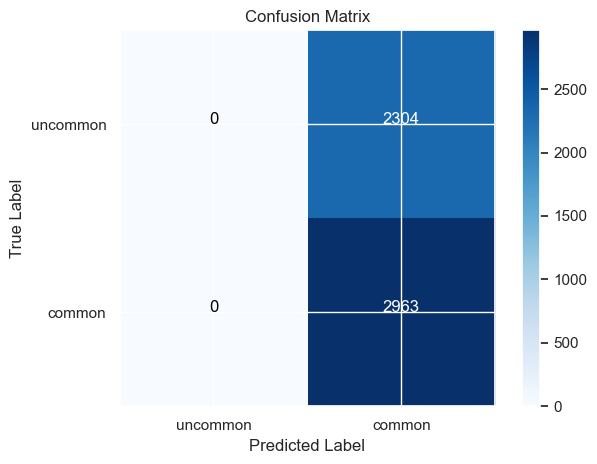

In [17]:
plot_confusion_matrix(y_train, dumb_pred_train)

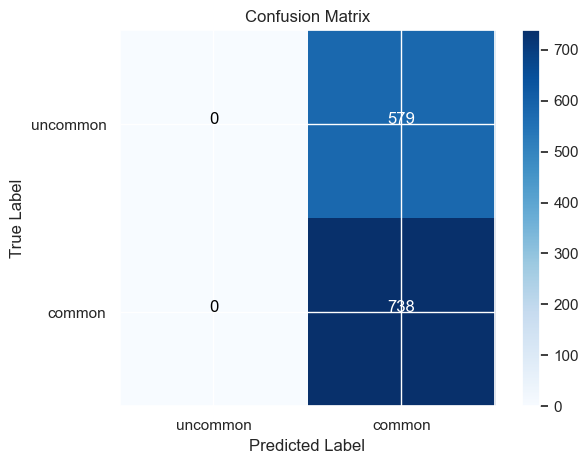

In [18]:
plot_confusion_matrix(y_test, dumb_pred_test)

We see that it correctly predicts 738 of the common diagnosis and incorrectly predicts 579 for the uncommon diagnosis. This will be our baseline for any other model performance.

## Modeling<a id='Modeling'></a>

Now let's test a model. We can try Logistic Regression first to make sure we can get the machine learning running smoothly and try to make sense of the results. 

In [19]:
#Try logistic regression first

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train,y_train)

y_pred_train = logreg.predict(X_train)
y_pred_test = logreg.predict(X_test)
(pd.DataFrame(y_pred_test, columns= diagnosis, index=y_test_index))

,common
CPSC_Case_Number,
170827787,1
160852455,0
170157166,0
141223560,1
130852418,1
...,...
161044669,1
130902754,1
171106994,1


Based on the results of our prediction, we can see for each case number, whether the expected diagnosis is common or not.

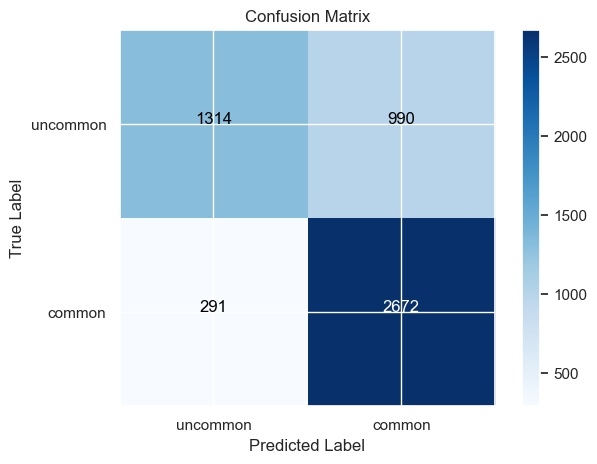

In [20]:
plot_confusion_matrix(y_train, y_pred_train)

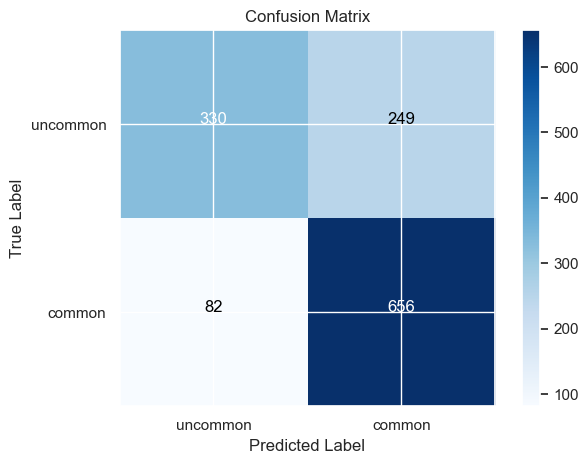

In [21]:
plot_confusion_matrix(y_test, y_pred_test)

After looking at the confusion matrix, we see that the model correct predicted 657 of the common diagnosis, and 330 of the uncommon diagnosis. It incorrectly thought 249 uncommon Diagnosis were actually common and 81 common diagnosis as uncommon. 

## Conclusion<a id='Conclusion'></a>